In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler
from astropy.io import ascii

In [5]:
CLUSTER_NAME: str = 'NGC 188'

In [29]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [7]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [8]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [9]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [10]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)
 (pm_l_cosb, pm_b) in mas / yr
    (-2.32538677, -0.91518539)>

# Plain DBSCAN

In [11]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_best_params.json', 'r') as f:
    best_params = json.load(f)

In [12]:
best_params

{'best_value': 1.024340676450316,
 'best_params': {'eps': 0.10033850561365287, 'min_samples': 15}}

In [ ]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(50):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.365, 25, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 13 labels.
Clustered: 843/957
843/957 sources from literature clustered
1491 clustered sources.
Classified into 11 labels.
Clustered: 831/957
831/957 sources from literature clustered
1471 clustered sources.
Classified into 13 labels.
Clustered: 832/957
832/957 sources from literature clustered
1466 clustered sources.
Classified into 11 labels.
Clustered: 834/957
834/957 sources from literature clustered
1487 clustered sources.
Classified into 12 labels.
Clustered: 830/957
830/957 sources from literature clustered
1447 clustered sources.
Classified into 13 labels.
Clustered: 833/957
833/957 sources from literature clustered
1458 clustered sources.
Classified into 12 labels.
Clustered: 817/957
817/957 sources from literature clustered
1471 clustered sources.
Classified into 8 labels.
Clustered: 828/957
828/957 sources from literature clustered
1468 clustered sources.
Classified into 18 labels.
Clustered: 829/957
829/957 sources from literature clustered
1435 clustered so

In [15]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

2452

In [37]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])

In [40]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])

In [18]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
24692,1636148068921376768,Gaia DR3 573215337576748032,573215337576748032,1211540435,2016.0,12.75807,0.683163,83.831284,0.738135,0.439317,...,0.743907,0.4669,0.276241,0.178231,0.707528,0.178769,8.364347,4.31998,0.193433,12
27629,1636148068921376768,Gaia DR3 573331031112965248,573331031112965248,373313069,2016.0,16.344492,0.27147,84.271933,0.255174,0.645406,...,0.822213,0.516048,0.305319,0.196993,2.279002,0.137678,8.230153,1.017172,0.13146,12
27945,1636148068921376768,Gaia DR3 573343327602348928,573343327602348928,1653900238,2016.0,16.251303,0.161993,84.523919,0.159452,0.413402,...,0.704754,0.442327,0.261702,0.168851,1.434931,0.052641,6.751232,0.914656,0.022381,12
28215,1636148068921376768,Gaia DR3 573354670612121088,573354670612121088,1494711348,2016.0,12.852203,0.035797,84.583456,0.034287,0.567896,...,0.430683,0.270311,0.159929,0.103187,0.828158,0.006719,5.087452,0.154759,0.008961,12
28291,1636148068921376768,Gaia DR3 573357419389008512,573357419389008512,1111982674,2016.0,14.492859,0.240622,84.622989,0.202919,0.43451,...,0.548142,0.344032,0.203546,0.131328,0.676147,0.105221,7.408975,1.28022,-0.051055,12


In [25]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [43]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/20.0

In [46]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/20.0

In [28]:
clustered['occurences'] = occurences/20.0
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences
24692,1636148068921376768,Gaia DR3 573215337576748032,573215337576748032,1211540435,2016.0,12.75807,0.683163,83.831284,0.738135,0.439317,...,0.4669,0.276241,0.178231,0.707528,0.178769,8.364347,4.31998,0.193433,12,0.05
27629,1636148068921376768,Gaia DR3 573331031112965248,573331031112965248,373313069,2016.0,16.344492,0.27147,84.271933,0.255174,0.645406,...,0.516048,0.305319,0.196993,2.279002,0.137678,8.230153,1.017172,0.13146,12,0.05
27945,1636148068921376768,Gaia DR3 573343327602348928,573343327602348928,1653900238,2016.0,16.251303,0.161993,84.523919,0.159452,0.413402,...,0.442327,0.261702,0.168851,1.434931,0.052641,6.751232,0.914656,0.022381,12,0.05
28215,1636148068921376768,Gaia DR3 573354670612121088,573354670612121088,1494711348,2016.0,12.852203,0.035797,84.583456,0.034287,0.567896,...,0.270311,0.159929,0.103187,0.828158,0.006719,5.087452,0.154759,0.008961,12,0.60
28291,1636148068921376768,Gaia DR3 573357419389008512,573357419389008512,1111982674,2016.0,14.492859,0.240622,84.622989,0.202919,0.43451,...,0.344032,0.203546,0.131328,0.676147,0.105221,7.408975,1.28022,-0.051055,12,0.25


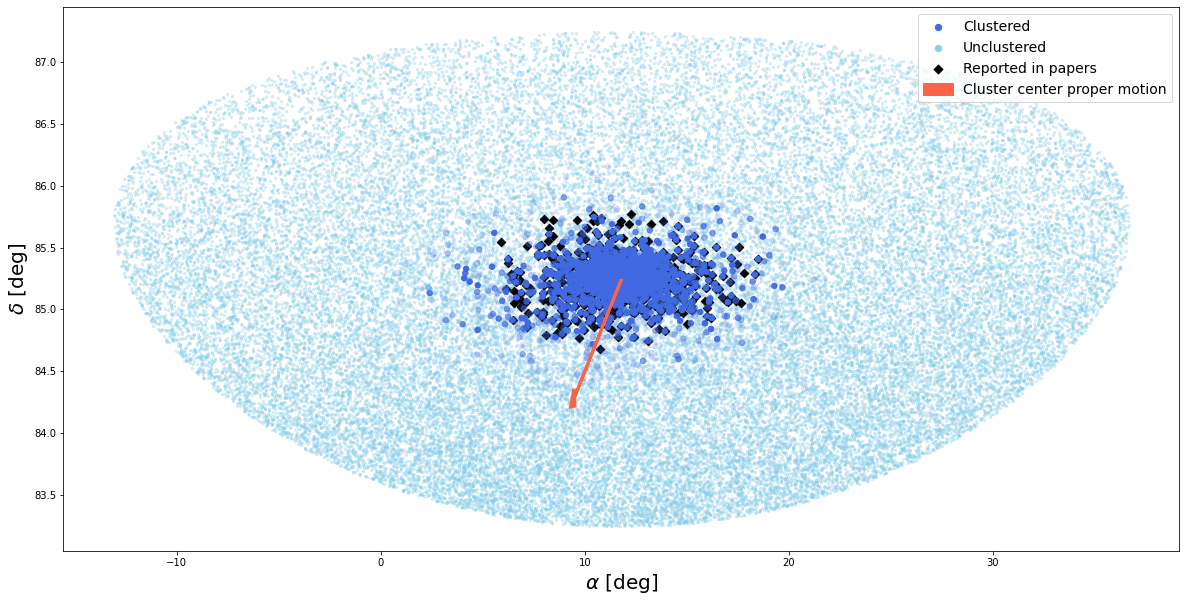

In [36]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='tomato',
          head_width=0.15,
          head_length=0.2,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

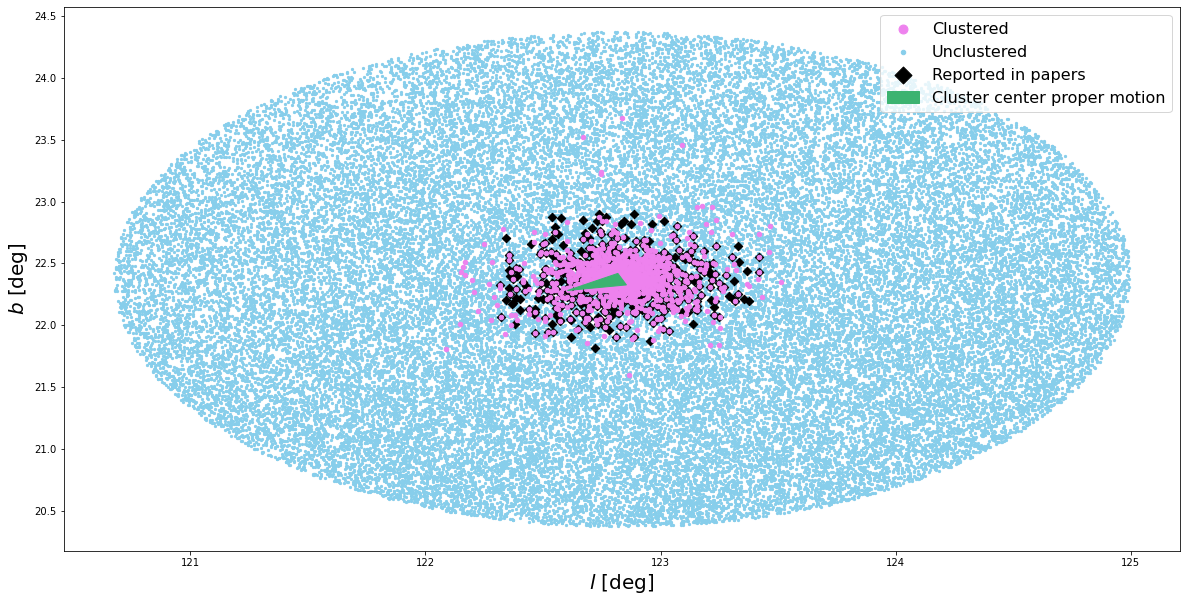

In [12]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.to(u.deg/u.yr).value,
          galactic_coords.pm_b.to(u.deg/u.yr).value,
          linewidth=1.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.25,
          zorder=4,
          label='Cluster center proper motion')
plt.legend(fontsize=16, loc='upper right', markerscale=2.);

In [47]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


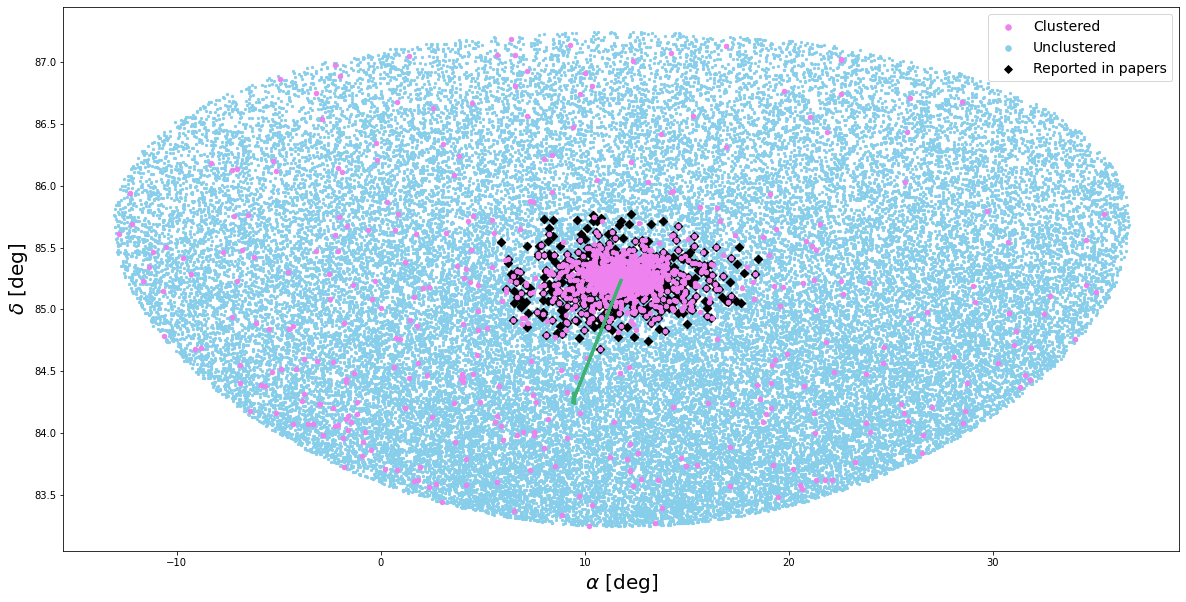

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

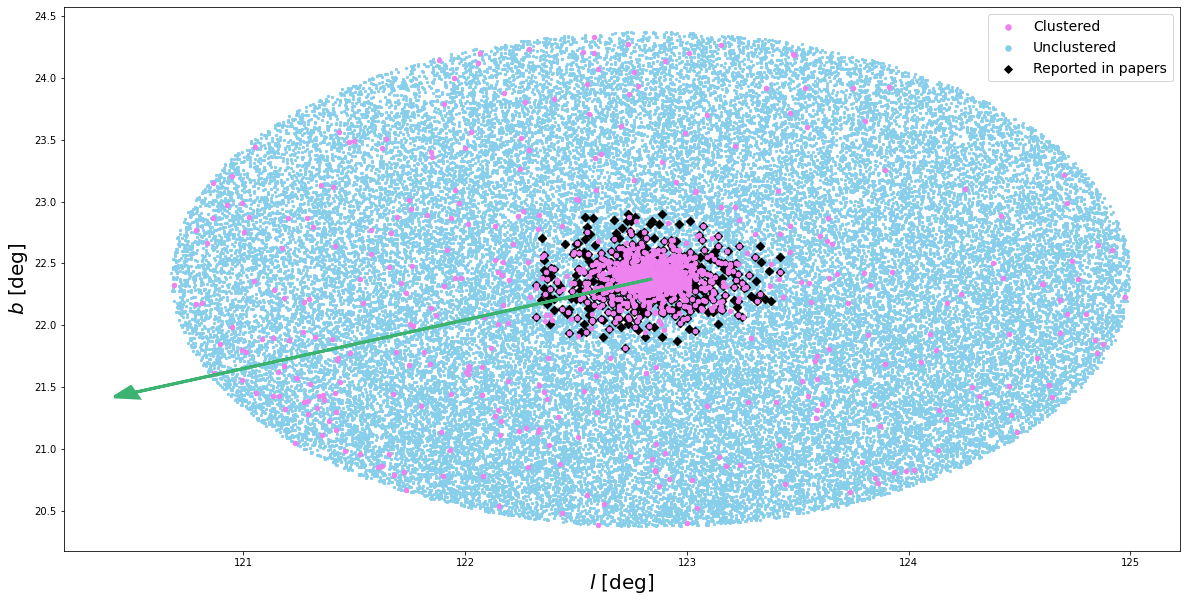

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();

# pyUPMASK

In [43]:
pyupmask = ascii.read('pyUPMASK/output/NGC 188.dat').to_pandas()

In [44]:
pyupmask.probs_final.value_counts()

 0.0000    439
-1.0000    310
 0.0001    104
 0.0002     47
 0.9919     45
          ... 
 0.9073      1
 0.8644      1
 0.8285      1
 0.9411      1
 0.0435      1
Name: probs_final, Length: 8976, dtype: int64

In [48]:
pyupmask = pd.concat([gaiadr3, pyupmask], axis=1)

In [64]:
pyupmask_clustered = pyupmask[pyupmask.probs_final>0.9]
pyupmask_noise = pyupmask[pyupmask.probs_final<=0.9]

In [65]:
pyupmask.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,excess,_x,_y,Plx,pmRA,pmDE,e_Plx,e_pmRA,e_pmDE,probs_final
0,1636148068921376768,Gaia DR3 574509467058245248,574509467058245248,1493410390,2016.0,35.762865,0.029851,85.164665,0.029967,0.545239,...,0.006768,2.016031,0.133456,0.437633,0.717436,-0.975232,0.252974,0.008907,0.012766,0.2798
1,1636148068921376768,Gaia DR3 574509467058245632,574509467058245632,671685054,2016.0,35.689345,0.127046,85.157645,0.129013,0.276671,...,0.160049,2.009767,0.126213,-1.532145,-1.054192,2.178639,1.089803,0.037095,0.052995,0.0078
2,1636148068921376768,Gaia DR3 574509497122165760,574509497122165760,998946401,2016.0,35.790532,0.125888,85.170221,0.133328,0.700458,...,-0.029463,2.018388,0.139189,1.576072,0.320745,-2.119458,1.106149,0.036445,0.053504,0.1133
3,1636148068921376768,Gaia DR3 574509634560358272,574509634560358272,1157546964,2016.0,35.942416,0.145537,85.191924,0.142934,0.419366,...,0.010691,2.031328,0.161580,-0.485563,-0.475731,1.301807,1.181067,0.042271,0.061019,0.2442
4,1636148068921376768,Gaia DR3 574512555138118272,574512555138118272,1114709481,2016.0,35.841332,0.352966,85.192230,0.388702,0.268799,...,0.217585,2.022716,0.161896,-1.589883,-0.618497,-0.312579,2.866479,0.100897,0.159106,0.4979


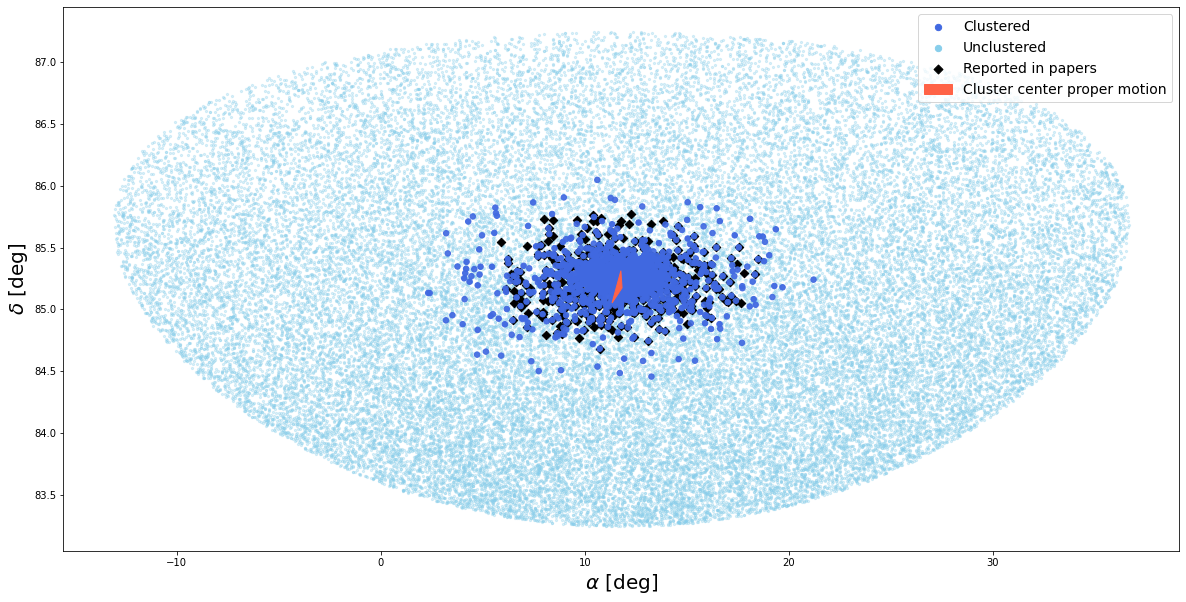

In [75]:
plt.figure(figsize=(20, 10))
plt.scatter(pyupmask_clustered.ra, pyupmask_clustered.dec, 
            color='royalblue', alpha=pyupmask_clustered.probs_final, 
            label='Clustered', zorder=2, s=30.)
plt.scatter(pyupmask_noise.ra, pyupmask_noise.dec, color='skyblue', 
            label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra*(u.arcsec/u.year).to(u.deg/u.year),
          cp_pmdec*(u.arcsec/u.year).to(u.deg/u.year),
          color='tomato',
          head_width=0.15,
          head_length=0.5,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

In [77]:
len(pyupmask_clustered)

1474

In [78]:
pyupmask_clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_pyupmask_clustered.csv')